In [1]:
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import csv
from functools import reduce
import re
import string

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import word_tokenize, pos_tag_sents, pos_tag
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
import os, glob
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
stops = set(stopwords.words("english")) 
wordnet_lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
usa_news = pd.read_csv('Annotations/usanews0/usanews.csv').fillna(0)
labels = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others", "Toxic"]
col = ["message", "Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others", "Toxic"]
usa_news[labels] = usa_news[labels].astype("float").replace(r'^\s*$', np.nan, regex=True).fillna(0).replace(np.nan,0)
usa_news = usa_news[col]
usa_news["none"] = (usa_news[labels].max(axis=1) == 0).astype(float)
usa_news

,message,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic,none
0,DEMOCRATS ARE TERRORISTS!,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,"Let's be honest, they aren't voting for Biden,...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Where would we be if not for RSBN?,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,THEY WON'T BE HAPPY WHEN THEY ARE REGULATED 😛😛😥,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,TRUMP 2020,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
16678,OUR VOTES WILL DRAIN THE SWAMP,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16679,"Biden MAY BE elected president Tuesday, BUT if...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
16680,Trump 2020,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16681,I DON'T WANT NO WOMAN FOR PRESIDENT!!!!!,0.0,1.0,0.0,0.0,0.0,0.0,0.0


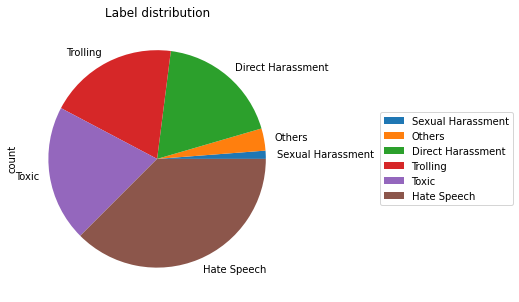

In [3]:
labels2 = ["Direct Harassment", "Hate Speech","Sexual Harassment","Trolling", "Others", "Toxic", "none"]
df_distribution = usa_news[labels2].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution',
                                      figsize=(5, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [4]:
df_distribution.sort_values('count', ascending=False)

,count
none,15241.0
Hate Speech,739.0
Toxic,399.0
Trolling,380.0
Direct Harassment,364.0
Others,65.0
Sexual Harassment,24.0


In [6]:
usa_news

,Unnamed: 0,Unnamed: 0.1,message,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic,cleaned_message,POS,tagCounts
0,0,0,DEMOCRATS ARE TERRORISTS!,0.0,1.0,0.0,0.0,0.0,0.0,DEMOCRATS ARE TERRORISTS!,"[('DEMOCRATS', 'PROPN'), ('be', 'AUX'), ('TERR...","{'PROPN': 2, 'AUX': 1, 'PUNCT': 1}"
1,1,1,"Let's be honest, they aren't voting for Biden,...",0.0,0.0,0.0,0.0,0.0,0.0,"Let us be honest, they are not voting for Bide...","[('let', 'VERB'), ('we', 'PRON'), ('be', 'VERB...","{'VERB': 6, 'PRON': 4, 'ADJ': 3, 'PUNCT': 2, '..."
2,2,2,Where would we be if not for RSBN?,0.0,0.0,0.0,0.0,0.0,0.0,Where would we be if not for RSBN?,"[('where', 'ADV'), ('would', 'AUX'), ('we', 'P...","{'ADV': 1, 'AUX': 1, 'PRON': 1, 'VERB': 1, 'SC..."
3,3,3,THEY WON'T BE HAPPY WHEN THEY ARE REGULATED 😛😛😥,0.0,1.0,0.0,0.0,0.0,0.0,THEY Will not BE HAPPY WHEN THEY ARE REGULATED...,"[('they', 'PRON'), ('will', 'AUX'), ('not', 'P...","{'PRON': 2, 'AUX': 2, 'PART': 1, 'VERB': 2, 'A..."
4,4,4,TRUMP 2020,0.0,0.0,0.0,0.0,0.0,0.0,TRUMP 2020,"[('TRUMP', 'PROPN'), ('2020', 'NUM')]","{'PROPN': 1, 'NUM': 1}"
...,...,...,...,...,...,...,...,...,...,...,...,...
16678,16678,39361,OUR VOTES WILL DRAIN THE SWAMP,0.0,0.0,0.0,0.0,0.0,0.0,OUR VOTES WILL DRAIN THE SWAMP,"[('our', 'PRON'), ('vote', 'NOUN'), ('will', '...","{'PRON': 1, 'NOUN': 2, 'AUX': 1, 'VERB': 1, 'D..."
16679,16679,39362,"Biden MAY BE elected president Tuesday, BUT if...",0.0,0.0,0.0,0.0,0.0,0.0,"Biden MAY BE elected president Tuesday, BUT if...","[('Biden', 'PROPN'), ('may', 'AUX'), ('be', 'A...","{'PROPN': 9, 'AUX': 4, 'VERB': 5, 'NOUN': 5, '..."
16680,16680,39363,Trump 2020,0.0,0.0,0.0,0.0,0.0,0.0,Trump 2020,"[('trump', 'NOUN'), ('2020', 'NUM')]","{'NOUN': 1, 'NUM': 1}"
16681,16681,39364,I DON'T WANT NO WOMAN FOR PRESIDENT!!!!!,0.0,1.0,0.0,0.0,0.0,0.0,I Do not WANT NO WOMAN FOR PRESIDENT!!!!!,"[('I', 'PRON'), ('do', 'AUX'), ('not', 'PART')...","{'PRON': 1, 'AUX': 1, 'PART': 1, 'VERB': 1, 'D..."


In [ ]:
from nltk.corpus import words
import contractions

def extract_words(text):
    text = contractions.fix(text)
    regex = re.compile('[' + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    return nopunct

def lemmatize(word, tag):
    if word == "trump" or word == "joe" or word == "biden":
        return ""
    elif tag.startswith('NN'):
        return wordnet_lemmatizer.lemmatize(word, pos='n')
    elif tag.startswith('VB'):
        return wordnet_lemmatizer.lemmatize(word, pos='v')
    elif tag.startswith('JJ'):
        return wordnet_lemmatizer.lemmatize(word, pos='a')
    else:
        return word

def tokenize(text):
    #tokens = nltk.pos_tag(nltk.word_tokenize(text))
    words = []
    for word, tag in tokens:
        words.append(lemmatize(word, tag))
    words = [w for w in words if not w in stops]
    words = [w for w in words if not w in string.punctuation]
    words = [w.lower() for w in words]
    return words

usa_news['clean_message'] = usa_news['message'].apply(extract_words)
usa_news['tokenized'] = usa_news['clean_message'].apply(tokenize)

In [ ]:
def get_tfidf_vect(documents):
    vectorizer = TfidfVectorizer(ngram_range=(2,3), tokenizer=tokenize, max_df=0.85, analyzer = 'word', min_df=1, max_features=10000, stop_words='english', lowercase=True)
    vector = vectorizer.fit_transform(documents)
    feature_names = np.array(vectorizer.get_feature_names())
    return pd.DataFrame(vector.todense(), columns=feature_names), vector, feature_names


In [ ]:
df, vector, features = get_tfidf_vect(usa_news['message'])
df[labels] = usa_news[labels]

In [ ]:
display(df)

In [ ]:
df.to_pickle("tfidf.pkl")

In [ ]:
top_words = {}
top_words_list = []
for label in labels:
    df_label = df[df[label] == 1.0]
    tfidf = df_label[features]
    combine = np.asarray(tfidf.reset_index(drop=True).sum(axis=0)
    #importance = np.argsort(np.asarray(tfidf.reset_index(drop=True).sum(axis=0)).ravel())[::-1]
    top_words[label] = list(features[importance[:10]])
    top_words_list.extend(list(features[importance[:10]]))

In [14]:
top_words = {}
top_words_list = []
for label in labels:
    df_label = df[df[label] == 1.0]
    tfidf = df_label[features]
    importance = np.argsort(np.asarray(tfidf.reset_index(drop=True).sum(axis=0)).ravel())[::-1]
    top_words[label] = list(features[importance[:10]])
    top_words_list.extend(list(features[importance[:10]]))

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
print(top_words_list)

['crime family', 'lady gaga', 'prison 2020', '47 year', 'cnn suck', 'moises sanchez', 'vice president', 'lock whitmer', 'big liar', 'nursing home', 'moron 2020', 'lady gaga', 'china pay', "ca n't", 'live matter', 'vote vote', 'china virus', 'remove democrat', 'fake news', 'moises sanchez', 'lady gag', 'lady gaga', 'hell kameltoe', 'buck fiden', 'commie bitch', 'gaga make gag', 'make gag lady', 'make gag', 'gag lady', 'gaga make', 'crime family', 'moron 2020', '📢📢📢breaking news', 'fake news', 'idiot vote', 'communist china', 'bye bye', 'china ccp', 'kamala harris', 'coronavirus hoax', 'sunny yu', 'live matter', 'terror attack', 'beijing prison', '47 year', 'veteran die', 'vice president', 'dont know', 'crazy greta', 'need help', 'lady gaga', 'moron 2020', 'cnn suck', 'prison 2020', 'moises sanchez', 'shit hole', 'nancy pelosi', 'liar marxist', 'crime family', 'brain dead']


C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
top_features = [w for w in features if w in top_words_list]
corr_columns = top_features + labels
df[corr_columns]

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,47 year,beijing prison,big liar,brain dead,buck fiden,bye bye,ca n't,china ccp,china pay,china virus,...,veteran die,vice president,vote vote,📢📢📢breaking news,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
df_corr = df[corr_columns].corr(method="spearman")
x = df_corr.drop(columns=top_features)
x.info()
x

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 47 year to Toxic
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Direct Harassment  51 non-null     float64
 1   Hate Speech        51 non-null     float64
 2   Sexual Harassment  51 non-null     float64
 3   Trolling           51 non-null     float64
 4   Others             51 non-null     float64
 5   Toxic              51 non-null     float64
dtypes: float64(6)
memory usage: 4.8+ KB


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
47 year,0.031678,-0.009289,-0.001638,-0.006587,0.019670,-0.006754
beijing prison,0.077185,0.053112,-0.000588,0.049532,0.061189,-0.002424
big liar,0.059197,-0.002887,-0.000509,-0.002047,-0.000839,-0.002099
brain dead,0.037000,0.052489,-0.000778,-0.003128,-0.001281,0.054258
buck fiden,0.028597,-0.002887,0.117438,-0.002047,-0.000839,-0.002099
bye bye,0.003619,-0.008984,-0.001584,0.012939,-0.002610,-0.006532
ca n't,0.009769,0.019762,-0.001837,0.000910,-0.003027,0.008663
china ccp,-0.002833,0.026645,-0.000720,0.039483,-0.001186,-0.002969
china pay,-0.003060,0.066716,-0.000778,0.016494,-0.001281,-0.003207
china virus,0.046628,0.054240,-0.000930,0.012677,-0.001532,0.012187


In [18]:
# for label in labels:
#     for top_f in top_features:
#         if not top_f in top_words[label]:
#             x.at[top_f,label] = np.nan

# x

df_labels_corr = []

for label_corr in labels:
    df_d_corr = pd.DataFrame(index=top_words[label_corr], columns=labels)

    for label in labels:
        for top_f in top_features:
            if top_f in top_words[label_corr]:
                df_d_corr.at[top_f,label] = x.at[top_f,label]
    df_d_corr = df_d_corr.style.set_caption(label_corr)
    df_labels_corr.append(df_d_corr)

for df in df_labels_corr:
    display(df)


C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
crime family,0.059536,0.020502,-0.001212,0.058075,-0.001997,0.031884
lady gaga,0.046202,0.027015,0.087405,-0.000524,0.014797,0.036119
prison 2020,0.057876,0.044370,-0.001470,0.025257,-0.002423,0.034528
47 year,0.031678,-0.009289,-0.001638,-0.006587,0.019670,-0.006754
cnn suck,0.062089,0.026647,-0.000720,-0.002896,-0.001186,0.079798
moises sanchez,0.089796,0.062293,-0.000509,-0.002047,-0.000839,0.085676
vice president,0.002584,-0.009840,-0.002516,-0.010121,0.010492,-0.004409
lock whitmer,0.037009,-0.004411,-0.000778,-0.003128,-0.001281,-0.003207
big liar,0.059197,-0.002887,-0.000509,-0.002047,-0.000839,-0.002099
nursing home,0.025241,-0.006012,-0.001060,0.010136,-0.001747,-0.004371


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
moron 2020,0.037009,0.080940,-0.000778,0.055726,-0.001281,0.073418
lady gaga,0.046202,0.027015,0.087405,-0.000524,0.014797,0.036119
china pay,-0.003060,0.066716,-0.000778,0.016494,-0.001281,-0.003207
ca n't,0.009769,0.019762,-0.001837,0.000910,-0.003027,0.008663
live matter,0.013901,0.062330,-0.001556,-0.006260,0.067935,0.031905
vote vote,-0.004564,0.018797,-0.003466,-0.000680,-0.005712,-0.009979
china virus,0.046628,0.054240,-0.000930,0.012677,-0.001532,0.012187
remove democrat,-0.005043,0.027311,-0.001282,-0.005155,-0.002112,-0.005286
fake news,0.017072,0.035659,-0.001907,0.048412,-0.003142,0.007785
moises sanchez,0.089796,0.062293,-0.000509,-0.002047,-0.000839,0.085676


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
lady gag,-0.003658,-0.005273,0.192940,-0.003739,-0.001532,-0.003834
lady gaga,0.046202,0.027015,0.087405,-0.000524,0.014797,0.036119
hell kameltoe,0.028599,-0.002887,0.117445,-0.002047,-0.000839,-0.002099
buck fiden,0.028597,-0.002887,0.117438,-0.002047,-0.000839,-0.002099
commie bitch,0.035840,0.024252,0.144035,-0.001672,-0.000685,0.034119
gaga make gag,-0.001635,-0.002357,0.288485,-0.001672,-0.000685,0.034119
make gag lady,-0.001635,-0.002357,0.288485,-0.001672,-0.000685,0.034119
make gag,-0.001635,-0.002357,0.288485,-0.001672,-0.000685,0.034119
gag lady,-0.001635,-0.002357,0.288485,-0.001672,-0.000685,0.034119
gaga make,0.028600,-0.002887,0.235370,-0.002047,-0.000839,0.027157


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
crime family,0.059536,0.020502,-0.001212,0.058075,-0.001997,0.031884
moron 2020,0.037009,0.080940,-0.000778,0.055726,-0.001281,0.073418
📢📢📢breaking news,-0.002313,-0.003334,-0.000588,0.075490,-0.000969,-0.002424
fake news,0.017072,0.035659,-0.001907,0.048412,-0.003142,0.007785
idiot vote,-0.002313,0.034298,-0.000588,0.075482,-0.000969,0.022914
communist china,0.057039,0.038261,-0.000778,0.075337,-0.001281,-0.003207
bye bye,0.003619,-0.008984,-0.001584,0.012939,-0.002610,-0.006532
china ccp,-0.002833,0.026645,-0.000720,0.039483,-0.001186,-0.002969
kamala harris,-0.004480,0.032421,-0.001139,0.035643,-0.001876,0.008392
coronavirus hoax,-0.002313,-0.003334,-0.000588,0.101435,-0.000969,-0.002424


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
sunny yu,0.059197,0.040566,-0.000509,-0.002047,0.142677,0.056417
live matter,0.013901,0.062330,-0.001556,-0.006260,0.067935,0.031905
terror attack,-0.005549,-0.007999,-0.001410,0.005142,0.049575,-0.005816
beijing prison,0.077185,0.053112,-0.000588,0.049532,0.061189,-0.002424
47 year,0.031678,-0.009289,-0.001638,-0.006587,0.019670,-0.006754
veteran die,-0.001635,-0.002357,-0.000416,-0.001672,0.087203,-0.001714
vice president,0.002584,-0.009840,-0.002516,-0.010121,0.010492,-0.004409
dont know,-0.002313,0.034301,-0.000588,-0.002364,0.061189,0.022920
crazy greta,0.035840,0.024252,-0.000416,-0.001672,0.087198,0.034119
need help,-0.003060,-0.004411,-0.000778,-0.003128,0.045712,0.015954


,Direct Harassment,Hate Speech,Sexual Harassment,Trolling,Others,Toxic
lady gaga,0.046202,0.027015,0.087405,-0.000524,0.014797,0.036119
moron 2020,0.037009,0.080940,-0.000778,0.055726,-0.001281,0.073418
cnn suck,0.062089,0.026647,-0.000720,-0.002896,-0.001186,0.079798
prison 2020,0.057876,0.044370,-0.001470,0.025257,-0.002423,0.034528
moises sanchez,0.089796,0.062293,-0.000509,-0.002047,-0.000839,0.085676
shit hole,0.059195,0.040565,-0.000509,-0.002047,-0.000839,0.085676
nancy pelosi,-0.004171,-0.006012,-0.001060,-0.004263,-0.001747,0.051863
liar marxist,-0.002313,0.053117,-0.000588,-0.002364,-0.000969,0.073595
crime family,0.059536,0.020502,-0.001212,0.058075,-0.001997,0.031884
brain dead,0.037000,0.052489,-0.000778,-0.003128,-0.001281,0.054258


In [47]:
#import required packages
#basic
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings
#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
#nlp
import string
import re     #for regex
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
def get_bow_vect(documents):
    vectorizer = CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, analyzer = 'word', max_features=10000, stop_words='english', lowercase=True)
    vector = vectorizer.fit_transform(documents)
    feature_names = np.array(vectorizer.get_feature_names())
    return pd.DataFrame(vector.todense(), columns=feature_names), vector, feature_names

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
documents = usa_news['message']
df_bow, bow_vector, bow_features = get_bow_vect(documents)

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Phoebe\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [32]:
display(df_bow)

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,'','' ``,'' `` https,'' come,'' use,'' use super,'' use💲superchat💲⬇⬇⬇⬇👍👍,'' ¡♡,'' ðÿ,'' ðÿ ‘,...,🧡 💛,🧡 💛 💙,🧱,🧱 rise,🧱 rise 🧱,🧱 tax,🧱 tax 🧱,🧱 🧱,🧱 🧱 tax,🧱 🧱 🧱
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:

texts =  [tokenize(text) for text in usa_news['message']]
texts

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['democrats', 'are', 'terrorists'],
 ['let',
  "'s",
  'honest',
  "n't",
  'vote',
  'biden',
  "'s",
  'kamala',
  'one',
  'keep',
  'secret',
  'person',
  'worst',
  'pick',
  'kamala'],
 ['where', 'would', 'rsbn'],
 ['they',
  'wo',
  "n't",
  'be',
  'happy',
  'when',
  'they',
  'are',
  'regulated',
  '😛😛😥'],
 ['trump', '2020'],
 ['salt', 'must', 'flow'],
 ['corn',
  'pop',
  'say',
  'i',
  'pity',
  'da',
  'fool',
  "n't",
  'eat',
  'mr',
  't',
  'cereal'],
 ['rsbn',
  'is',
  'the',
  'greatest',
  'gift',
  'for',
  'this',
  'climactic',
  'moment',
  'in',
  'american',
  'history'],
 ['trump', '95', 'in', 'california🤩🤩🤩🤩🤩🤩🤩🤩'],
 ['💙', 'bide\u200en', 'fo\u200dr', 'racism', '💙'],
 ['oe',
  'biden',
  'is',
  'a',
  'trojan',
  'horse',
  'for',
  'socialism',
  'thru',
  'sanders',
  'aoc',
  'omar',
  'pressley',
  'tlaib',
  'vote',
  'these',
  'socialists',
  'out',
  'of',
  'office',
  'stand',
  'our',
  'country',
  'our',
  'constitution',
  'our',
  'freedo

In [44]:
import gensim
import pprint
from gensim import corpora
from gensim.utils import simple_preprocess
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in texts]

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.052*"66" + 0.047*"69" + 0.046*"280" + 0.043*"279" + 0.039*"440" + '
  '0.032*"62" + 0.031*"63" + 0.031*"1983" + 0.029*"70" + 0.027*"288"'),
 (1,
  '0.157*"4" + 0.095*"3" + 0.025*"1415" + 0.024*"1414" + 0.024*"339" + '
  '0.016*"87" + 0.013*"347" + 0.012*"660" + 0.011*"1916" + 0.011*"7600"'),
 (2,
  '0.121*"51" + 0.096*"424" + 0.057*"49" + 0.041*"231" + 0.032*"156" + '
  '0.031*"403" + 0.020*"9" + 0.018*"52" + 0.018*"240" + 0.015*"226"'),
 (3,
  '0.051*"40" + 0.042*"1038" + 0.040*"1145" + 0.034*"5224" + 0.033*"1118" + '
  '0.023*"106" + 0.020*"348" + 0.018*"1083" + 0.017*"934" + 0.017*"693"'),
 (4,
  '0.275*"27" + 0.143*"14" + 0.069*"44" + 0.069*"26" + 0.041*"3722" + '
  '0.028*"643" + 0.027*"656" + 0.026*"2078" + 0.020*"254" + 0.016*"450"'),
 (5,
  '0.163*"111" + 0.089*"3966" + 0.067*"110" + 0.037*"114" + 0.024*"1082" + '
  '0.022*"457" + 0.020*"1419" + 0.020*"11" + 0.018*"5416" + 0.017*"19"'),
 (6,
  '0.052*"36" + 0.050*"239" + 0.050*"170" + 0.047*"146" + 0.036*"59" + '
  '0

C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Phoebe\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: object of type 'int' has no len()